<a href="https://colab.research.google.com/github/Sujith1208/Assignment-for-NLP-Project/blob/main/Emotion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have divided the problem statement into two parts :
1) Finding the emotion of the tweet
2) Finding the Brand which the tweet is directed to

Here, We deal with first part of the problem
  Our objective is to find the emotion of the tweet.
  Firstly, I have uploaded the dataset in my googledrive and imported that dataset into Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


I have imported all the required libraries an the dataset.
I have checked for the null values in the dataset and removed all the stopwords in the dataset and performed all the preprocessings steps.  
Performed Exploratory Data Analysis (EDA) on the dataset and reported the findings about
observations and patterns in the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8588 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8589 non-null   object
dtypes: object(3)
memory usage: 201.4+ KB
None
tweet_text                                               1
emotion_in_tweet_is_directed_at                       5298
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


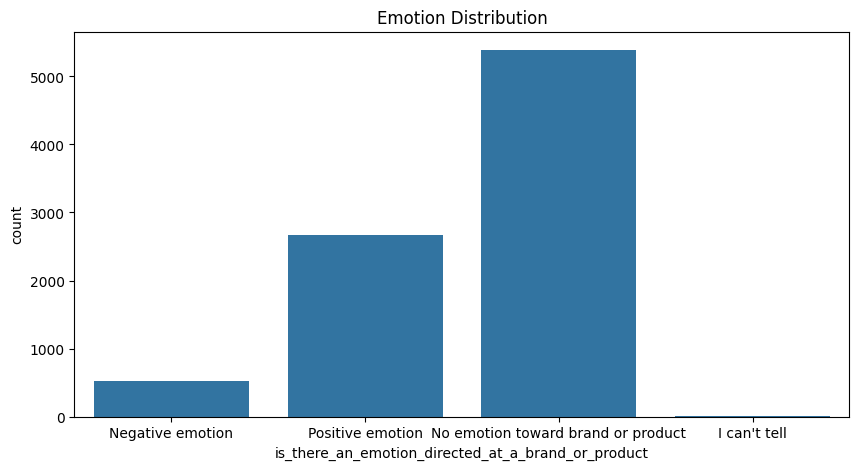

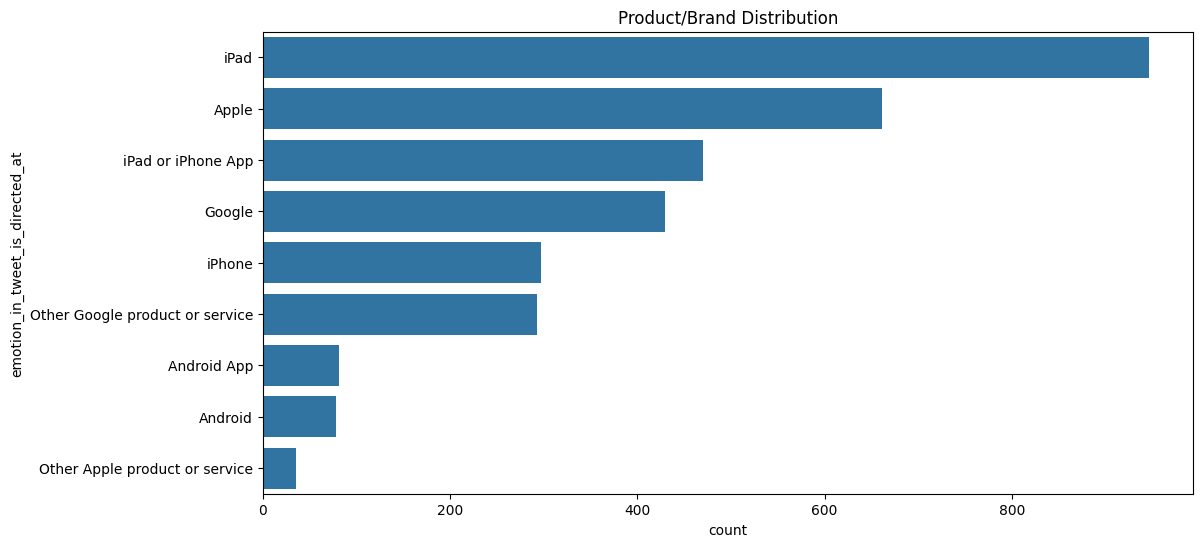

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Load the dataset
file_path = '/content/drive/MyDrive/NLP Engineer Assignment Dataset (1) .xlsx'
train_data = pd.read_excel(file_path, sheet_name='Train')
test_data = pd.read_excel(file_path, sheet_name='Test')

# Basic Info
print(train_data.info())

# Check for missing values
print(train_data.isnull().sum())

# Distribution of emotions
emotion_counts = train_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
product_counts = train_data['emotion_in_tweet_is_directed_at'].value_counts()

# Plotting
plt.figure(figsize=(10, 5))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=train_data)
plt.title('Emotion Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(y='emotion_in_tweet_is_directed_at', data=train_data, order=train_data['emotion_in_tweet_is_directed_at'].value_counts().index)
plt.title('Product/Brand Distribution')
plt.show()


Performed all the primary tasks of NLP like
Droping the missing values, resampling the dataset and defined the classisfication states of the problem.    
Split the data set into training and validation sets and performed the tokenization of text data using BertTokenizer.

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Handle missing values (if needed)
train_data.dropna(inplace=True)

# Balancing classes (optional)
# Upsample minority class
negative = train_data[train_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']
positive = train_data[train_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']

# Resampling to match counts
positive_upsampled = resample(positive, replace=True, n_samples=len(negative), random_state=42)
train_balanced = pd.concat([negative, positive_upsampled])

# Splitting the data
X = train_balanced['tweet_text']
y = train_balanced['is_there_an_emotion_directed_at_a_brand_or_product']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizing the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_data(texts, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


This is the crusial part of the problem,
Imported transformers for model training and Used BERT for Sequence Classification.
Used Trainer from the tronsformer library to further finetune the BERT transformer.

Used external API called wandb for Trainer , It asks for a API key for executing , which can be found at there site.

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score

# Model initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Convert labels to numerical values
label_dict = {'Positive emotion': 1, 'Negative emotion': 0}
y_train_labels = y_train.map(label_dict).values
y_val_labels = y_val.map(label_dict).values

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add the labels to the item
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances
train_dataset = CustomDataset(train_encodings, y_train_labels)
val_dataset = CustomDataset(val_encodings, y_val_labels)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)  # Calculate accuracy
    return {
        'accuracy': acc,  # Include accuracy in the output
    }


# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,       # Use custom datasets
    eval_dataset=val_dataset,  # Use custom datasets
    compute_metrics=compute_metrics,
)

# Training the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-1e9d43f16748>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.419842,0.865385
2,No log,0.371920,0.870192
3,No log,0.555415,0.860577


<ipython-input-11-1e9d43f16748>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1e9d43f16748>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1e9d43f16748>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=312, training_loss=0.35227286509978467, metrics={'train_runtime': 2089.1941, 'train_samples_per_second': 1.192, 'train_steps_per_second': 0.149, 'total_flos': 74215817607600.0, 'train_loss': 0.35227286509978467, 'epoch': 3.0})

Trained the model in BERT and Validated with validation data to get an accuracy of 86.05

In [ ]:
# Evaluate the model
results = trainer.evaluate()

print(f"Validation Loss: {results['eval_loss']}")
print(f"Validation Accuracy: {results['eval_accuracy']}")

# Predict on the test set
#test_encodings = tokenize_data(test_data['Tweet'])
#predictions = trainer.predict([test_encodings])
test_dataset = [
    {k: v[i].tolist() for k, v in test_encodings.items()}
    for i in range(len(test_data))
]
predictions = trainer.predict(test_dataset=test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)


<ipython-input-11-1e9d43f16748>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Validation Loss: 0.5554152727127075
Validation Accuracy: 0.8605769230769231


Tested the model against the test data to get the emotion of the tweets in the test dataset and Printed the output of emotionclassification for the test data

In [ ]:
for i, label in enumerate(predicted_labels):
    tweet = test_data['Tweet'][i]
    predicted_emotion = "Positive emotion" if label == 1 else "Negative emotion"
    print(f"Tweet: {tweet}")
    print(f"Predicted Emotion: {predicted_emotion}\n")

Tweet: Hand-Held ���Hobo�۪: Drafthouse launches ���Hobo With a Shotgun�۪ iPhone app #SXSW {link}
Predicted Emotion: Positive emotion

Tweet: Again? RT @mention Line at the Apple store is insane.. #sxsw
Predicted Emotion: Negative emotion

Tweet: Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw
Predicted Emotion: Positive emotion

Tweet: Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
Predicted Emotion: Positive emotion

Tweet: ���@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow
Predicted Emotion: Positive emotion

Tweet: Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw
Predicted Emotion: Negative emotion

Tweet: Spark for #android is up for a #teamandroid award at #SXSW read about it here: {link}
Predicted Emotion: Positive emotion

Tweet: Does yo